In [1]:
# Install Missing Dependencies
!pip install -q torchinfo torchmetrics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.2 MB/s eta 0:00:00


In [30]:
import torch
import torchvision

from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassConfusionMatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# DEBUG:
device

'cuda'

In [4]:
# Get Data
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
!mkdir -p data
!unzip -n pizza_steak_sushi.zip -d data/pizza_steak_sushi

--2025-04-01 14:40:38--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2025-04-01 14:40:39--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.1s    

2025-04-01 14:40:39 (156 MB/s) - ‘pizza_steak

In [5]:
# Create a Transforms Pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape ALL Images to 224x224 (SOME Models may Require Different Sizes)
    transforms.ToTensor(), # 2. Turn Image Values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
# Create Training and Testing DataLoader's
data_path = "data/pizza_steak_sushi"

train_dset = ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset = ImageFolder(f"{data_path}/test", transform=simple_transform)

train_dataloader = DataLoader(train_dset, batch_size=32, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_dset, batch_size=32, num_workers=2)

In [7]:
# Get the List of Class Names
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")

Class names: ['pizza', 'sushi', 'steak']


In [8]:
# Setup the Model with Pre-Trained Weights and Send it to the Target Device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# DEBUG:
model_0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Freeze ALL Base Layers in the 'Features' Section of the Model (Feature Extractor)
# by Setting 'requires_grad=False'
for param in model_0.features.parameters():
    param.requires_grad = False

In [10]:
# Set the Manual Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [11]:
# Get the Length of 'class_names'
output_shape = len(class_names)

# DEBUG:
output_shape

3

In [12]:
# Recreate the Classifier Layer and Seed it to the Target Device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # SAME #Output Units as our #Classes
                    bias=True)).to(device)

In [14]:
# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [15]:
# Train the Model
def train(model, optimizer, dataloader, loss_fn):
  # Set the Model on the Training Mode
  model.train()

  # running_loss -> Total Loss across the Whole Epoch
  running_loss = 0.0

  # correct -> #Images Predicted CORRECTLY
  correct = 0

  # total -> #Images Seen
  total = 0

  # Loops over EACH Batch in Training Set
  for batch_idx, (inputs, targets) in enumerate(dataloader):
    # Move inputs (batch of Images) and targets (True Class Labels) to GPU
    inputs, targets = inputs.cuda(), targets.cuda()

    # Pass inputs (batch of Iamges) to the Model:
    # outputs -> Tensor of logits [B, 200]
    outputs = model(inputs)

    # Compute the Loss/Error
    # between the Predictions (outputs) and the True Labels(targets)
    # loss -> Single Scalar Loss Value
    loss = loss_fn(outputs, targets)

    # Backpropagation:
    optimizer.zero_grad() # -> Reset the Gradients of Model Parameters
    loss.backward() # -> Compute the Gradients of Loss with respect to EACH Weight & EACH Bias
    optimizer.step() # -> Update the Model's Parameters using the Gradients

    # Add the Scalar Loss Value (.item() is Needed) to the Total Loss
    running_loss += loss.item()

    # Get the Predicted Class (Class with the Max Score from outputs):
    # _, -> NO Save the Max Score
    # predicted -> Save ONLY the Predicted Class associated wit the Max Score
    _, predicted = outputs.max(1)

    # #Samples that were in this Batch:
    # - targets -> Tensor of shape: [B]
    # - .size(0) -> Return #Elements in targets
    total += targets.size(0)

    # Compare Predicted Labels (predicted) and True Labels (True Labels)
    # - .sum() -> Sum the 1s (Correct Predictions in the Batch)
    # - .item() -> Extract the Scalar Value
    correct += predicted.eq(targets).sum().item()

    # Compute the Average Loss per Batch
    train_loss = running_loss / len(dataloader)

    # Compute the Overall Accuracy for the Epoch
    train_accuracy = 100. * correct / total

    # DEBUG:
    print(f'Train Loss: {train_loss:.6f} Train Accuracy: {train_accuracy:.2f}%')

In [16]:
# Test the Model
def test(model, dataloader, loss_fn):
  # Set the Model on the Evaluation Mode
  model.eval()

  # test_loss -> Total Loss across ALL Test Batches
  test_loss = 0

  # correct -> #Images Predicted CORRECTLY
  correct = 0

  # total -> #Images Seen
  total = 0

  # Disable Gradient Calculations (BECAUSE we're in Testing)
  with torch.no_grad():
    # Loops over EACH Batch in the Test Set
    for batch_idx, (inputs, targets) in enumerate(dataloader):
      # Move inputs (batch of Images) and targets (True Class Labels) to GPU
      inputs, targets = inputs.cuda(), targets.cuda()

      # Pass inputs (batch of Images) to the Model:
      # outputs -> Tensor of logits [B, 200]
      outputs = model(inputs)

      # Compute the Loss/Error
      # between the Predictions (outputs) and the True Labels (targets)
      # loss -> Single Scalar Loss Value
      loss = loss_fn(outputs, targets)

      # Add the Scalar Loss Value (.item() is Needed) to the Total Loss
      test_loss += loss.item()

      # Get the Predicted Class (Class with the Max Score from outputs):
      # _, -> NO Save the Max Score
      # predicted -> Save ONLY the Predicted Class associated with the Max Score
      _, predicted = outputs.max(1)

      # #Samples that were in this Batch:
      # - targets -> Tensor of shape: [B]
      # - .size(0) -> Return #Elements in targets
      total += targets.size(0)

      # Compare Predicted Labels (predicted) and True Labels (targets)
      # - .sum() -> Sum the 1s (Correct Predictions in the Batch)
      # - .item() -> Extract the Scalar Value
      correct += predicted.eq(targets).sum().item()

    # Compute the Average Loss per Batch
    test_loss = test_loss / len(dataloader)

    # Compute the Overall Accuracy for the Epoch
    test_accuracy = 100. * correct / total

    # DEBUG:
    print(f'Test Loss: {test_loss:.6f} Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

In [17]:
# Set the Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [18]:
# Start the Timer
from timeit import default_timer as timer
start_time = timer()

# Setup Training and Save the Results
for _ in range(1000):
    train(model_0, optimizer, train_dataloader, loss_fn)
    test_acc = test(model_0, test_dataloader, loss_fn)
    print(f"Test Accuracy: {test_acc}")  # We should Get Values around 90% Accuracy on the Test Set


# End the Timer and Print out How Long it Took
end_time = timer()
print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")

Output streaming troncato alle ultime 5000 righe.
Train Loss: 0.005605 Train Accuracy: 100.00%
Train Loss: 0.008512 Train Accuracy: 100.00%
Train Loss: 0.011897 Train Accuracy: 100.00%
Train Loss: 0.016408 Train Accuracy: 100.00%
Train Loss: 0.023176 Train Accuracy: 99.48%
Train Loss: 0.037036 Train Accuracy: 98.66%
Train Loss: 0.196780 Train Accuracy: 98.22%
Test Loss: 0.295196 Test Accuracy: 93.33%
Test Accuracy: 93.33333333333333
Train Loss: 0.001212 Train Accuracy: 100.00%
Train Loss: 0.002577 Train Accuracy: 100.00%
Train Loss: 0.005969 Train Accuracy: 100.00%
Train Loss: 0.013560 Train Accuracy: 100.00%
Train Loss: 0.031328 Train Accuracy: 99.38%
Train Loss: 0.036253 Train Accuracy: 99.48%
Train Loss: 0.039313 Train Accuracy: 99.55%
Train Loss: 0.194246 Train Accuracy: 99.11%
Test Loss: 0.266158 Test Accuracy: 92.00%
Test Accuracy: 92.0
Train Loss: 0.001176 Train Accuracy: 100.00%
Train Loss: 0.004060 Train Accuracy: 100.00%
Train Loss: 0.005376 Train Accuracy: 100.00%
Train Loss

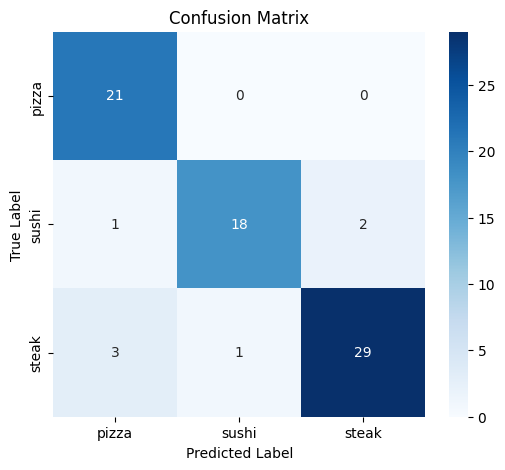

In [20]:
# Make a Confusion Matrix with the Test Predictions and the True Labels
def plot_confusion_matrix(model, dataloader, class_names):
  # Set the Model on the Evaluation Mode
  model.eval()

  # Initialize 2 Empty Lists
  # for Saving ALL Predictions and ALL True Labels
  # from the WHOLE Dataset, Batch by Batch
  all_preds = []
  all_targets = []

  # Disable Gradient Calculations (BECAUSE we're in Testing)
  with torch.no_grad():
    # Loops over EACH Batch in the Test Set
    for inputs, targets in dataloader:
      # Move inputs (batch of Images) and targets (True Class Labels) to GPU
      inputs, targets = inputs.cuda(), targets.cuda()

      # Pass inputs (batch of Images) to the Model:
      outputs = model(inputs)

      # Get the Predicted Class (Class with the Max Score from outputs):
      preds = outputs.argmax(dim=1)

      # Save EACH Batch's Prediction & EACH True Label
      all_preds.append(preds)
      all_targets.append(targets)

    # Concatenate ALL Batches into Single Tensors
    # for Computing the Confusion on the Full Test Set
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)


    # Get the Confusion Matrix
    confmat = MulticlassConfusionMatrix(num_classes=len(class_names)).to(device)
    conf_matrix = confmat(all_targets, all_preds).cpu().numpy()

    # Plotting with Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# DEBUG:
plot_confusion_matrix(model_0, test_dataloader, class_names)

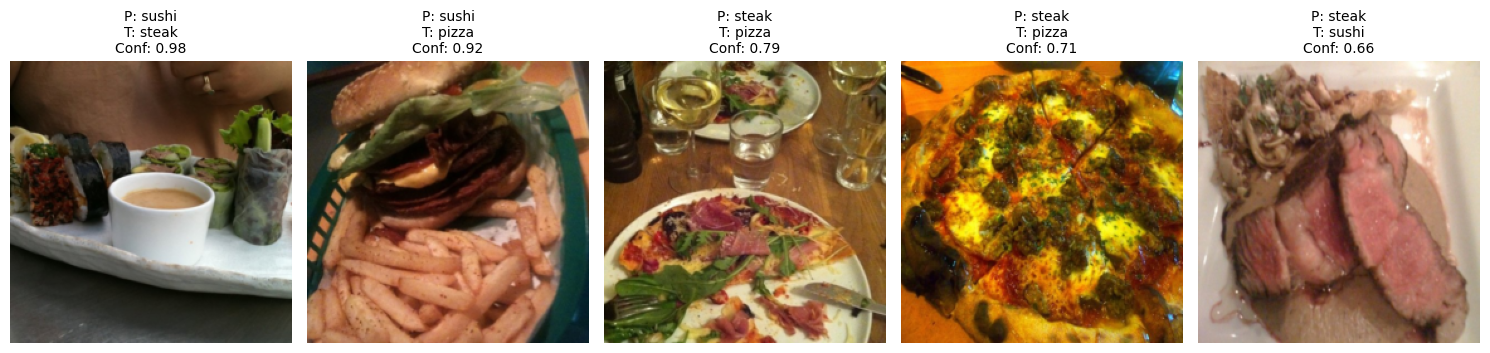

In [25]:
# Get the MOST Wrong of the Predictions on the Test Dataset,
# Plotting the 5 MOST Wrong Images
def plot_most_wrong(model, dataloader, class_names):
  # Set the Model on the Evaluation Mode
  model.eval()

  # Initialize Empty List for Saving:
  # 1) Image
  # 2) True Label
  # 3) Predicted Label
  # 4) Predicted Probability
  image_list = []
  true_targets = []
  pred_labels = []
  pred_probs = []

  # Disable Gradient Calculations (BECAUSE we're in Testing)
  with torch.no_grad():
    # Loops over EACH Batch in the Test Set
    for inputs, targets in dataloader:
      # Move inputs (batch of Images) and targets (True Class Labels) to GPU
      inputs, targets = inputs.cuda(), targets.cuda()

      # Pass inputs (batch of Images) to the Model:
      outputs = model(inputs)

      # Convert logits into Probabilities
      probs = F.softmax(outputs, dim=1)

      # Compute the:
      # 1) Class with the HIGHEST Probability
      # 2) Actual Confidence
      top_probs, top_preds = torch.max(probs, dim=1)

      # Move EVERYTHING Back to CPU for Plotting and Store EVERYTHING
      image_list.extend(inputs.cpu())
      true_targets.extend(targets.cpu())
      pred_labels.extend(top_preds.cpu())
      pred_probs.extend(top_probs.cpu())

    # Create a DataFrame
    df = pd.DataFrame({
        "image": image_list,
        "label": true_targets,
        "prediction": pred_labels,
        "pred_prob": pred_probs
    })

    # Add a Column: is the Prediction Correct?
    df["correct"] = df["label"] == df["prediction"]

    # Filter ONLY the Wrong Predictions
    most_wrong = df[df["correct"] == False]

    # Sort by Confidence (descending)
    most_wrong = most_wrong.sort_values(by="pred_prob", ascending=False)

    # Plot Top 5
    plt.figure(figsize=(15, 8))
    for i in range(min(5, len(most_wrong))):
      sample = most_wrong.iloc[i]
      image = sample["image"]
      true_label = class_names[sample["label"]]
      predicted_label = class_names[sample["prediction"]]
      confidence = sample["pred_prob"]

      plt.subplot(1, 5, i+1)
      img = image.permute(1, 2, 0).numpy()
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      img = (img * std) + mean
      img = img.clip(0, 1)

      plt.imshow(img)
      plt.axis("off")
      plt.title(f"P: {predicted_label}\nT: {true_label}\nConf: {confidence:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()


# DEBUG:
plot_most_wrong(model_0, test_dataloader, class_names)

In [26]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
!mkdir -p data
!unzip pizza_steak_sushi_20_percent.zip -d data/pizza_steak_sushi_20_percent

--2025-04-01 15:04:40--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip [following]
--2025-04-01 15:04:40--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31491084 (30M) [application/zip]
Saving to: ‘pizza_steak_sushi_20_percent.zip’

pizza_steak_sushi_2 100%[===================>]  30.03M  --.-KB/s    in 0.1s    

2

In [27]:
# Create a Transforms Pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape ALL Images to 224x224 (SOME Models may Require Different Sizes)
    transforms.ToTensor(), # 2. Turn Image Values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [28]:
# Create Training and Testing DataLoader's
data_path = "data/pizza_steak_sushi"

train_dset_20p= ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset_20p = ImageFolder(f"{data_path}/test", transform=simple_transform)

train_dataloader_20p = DataLoader(train_dset_20p, batch_size=32, num_workers=2, shuffle=True)
test_dataloader_20p = DataLoader(test_dset_20p, batch_size=32, num_workers=2)

In [29]:
# Get the List of Class Names
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")

Class names: ['pizza', 'sushi', 'steak']


In [31]:
# Get the Pre-Trained ResNet
model_resnet18 = models.resnet18(pretrained=True).to(device)

# Freeze the Feature Extractor
for param in model_resnet18.parameters():
    param.requires_grad = False

# Get #Features in the LAST Fully Connected Layer
num_ftrs = model_resnet18.fc.in_features

# Replace the LAST Fully Connected Layer with a New Layer for our 3 Classes
model_resnet18.fc = nn.Linear(num_ftrs, len(class_names))

model_resnet18 = model_resnet18.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [33]:
# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-3)

# Train and Test the Model
for epoch in range(10):
    print(f"\nEpoch {epoch+1}")
    train(model_resnet18, optimizer, train_dataloader_20p, loss_fn)
    test(model_resnet18, test_dataloader_20p, loss_fn)


Epoch 1
Train Loss: 0.070326 Train Accuracy: 100.00%
Train Loss: 0.160431 Train Accuracy: 87.50%
Train Loss: 0.242192 Train Accuracy: 85.42%
Train Loss: 0.332325 Train Accuracy: 82.81%
Train Loss: 0.406003 Train Accuracy: 82.50%
Train Loss: 0.465862 Train Accuracy: 84.90%
Train Loss: 0.544054 Train Accuracy: 85.71%
Train Loss: 0.686619 Train Accuracy: 85.33%
Test Loss: 0.708475 Test Accuracy: 82.67%

Epoch 2
Train Loss: 0.066868 Train Accuracy: 90.62%
Train Loss: 0.140308 Train Accuracy: 84.38%
Train Loss: 0.207146 Train Accuracy: 83.33%
Train Loss: 0.279162 Train Accuracy: 79.69%
Train Loss: 0.355988 Train Accuracy: 77.50%
Train Loss: 0.454021 Train Accuracy: 73.44%
Train Loss: 0.530335 Train Accuracy: 73.21%
Train Loss: 0.612098 Train Accuracy: 73.33%
Test Loss: 0.611170 Test Accuracy: 84.00%

Epoch 3
Train Loss: 0.066909 Train Accuracy: 84.38%
Train Loss: 0.128418 Train Accuracy: 82.81%
Train Loss: 0.207234 Train Accuracy: 78.12%
Train Loss: 0.276949 Train Accuracy: 78.12%
Train Lo